In [746]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

In [747]:
historical = pd.read_json('historical.json')
fear = pd.read_json('fear.json')

In [748]:
historical['time'] = pd.to_datetime(historical['time'], unit='s')
fear.rename(columns={'timestamp': 'time'}, inplace=True)

In [749]:
historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2001 entries, 0 to 2000
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   time              2001 non-null   datetime64[ns]
 1   high              2001 non-null   float64       
 2   low               2001 non-null   float64       
 3   open              2001 non-null   float64       
 4   volumefrom        2001 non-null   float64       
 5   volumeto          2001 non-null   float64       
 6   close             2001 non-null   float64       
 7   conversionType    2001 non-null   object        
 8   conversionSymbol  2001 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 140.8+ KB


In [750]:
fear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   value                 2000 non-null   int64         
 1   value_classification  2000 non-null   object        
 2   time                  2000 non-null   datetime64[ns]
 3   time_until_update     1 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 62.6+ KB


In [751]:
data = pd.merge(fear, historical, on='time', how='left')
data.drop(columns=['time_until_update', 'conversionType', 'conversionSymbol', 'value_classification'], inplace=True)
data.rename(columns={"value": "fear_greed"}, inplace=True)
data.dropna(inplace=True)

In [752]:
data.head()

,fear_greed,time,high,low,open,volumefrom,volumeto,close
0,51,2025-02-17,97046.20,95226.61,96132.69,12161.59,1.167316e+09,95675.58
1,54,2025-02-16,97728.27,96069.15,97596.21,6632.76,6.431463e+08,96132.69
2,50,2025-02-15,97979.54,97245.24,97508.71,5831.48,5.691206e+08,97596.21
3,48,2025-02-14,98869.28,96282.72,96632.78,20187.22,1.966705e+09,97508.71
4,50,2025-02-13,98104.11,95225.08,97874.61,23246.76,2.236345e+09,96632.78


In [753]:

# data_last_day = data.groupby(data['time'].dt.to_period('M')).last()
# data_last_day.head()

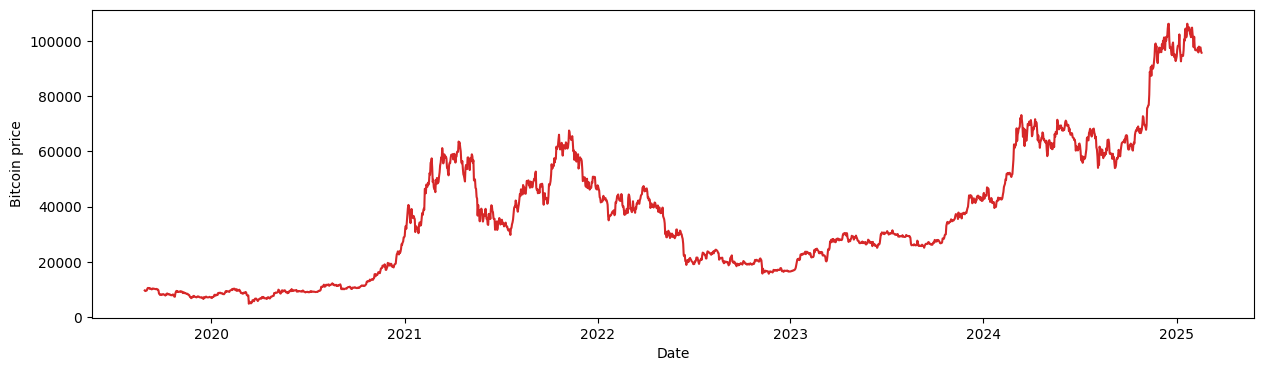

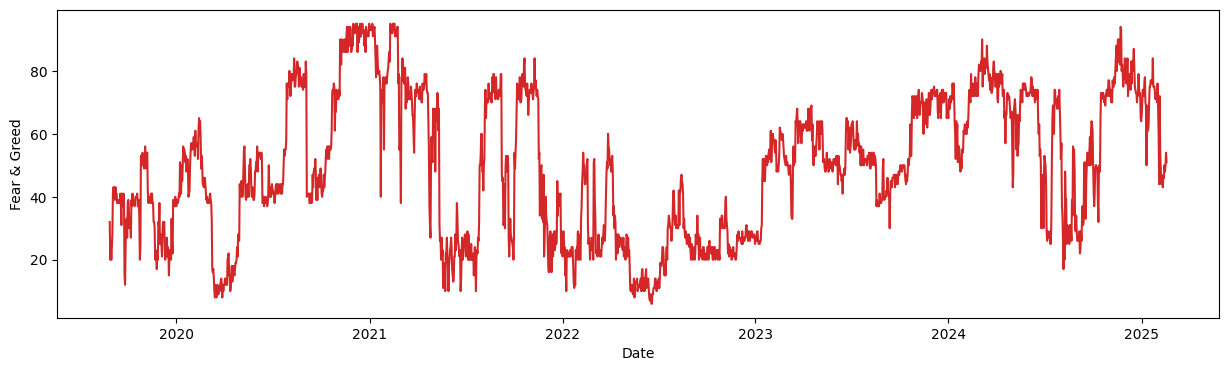

In [754]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Number of Passengers', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(data, data['time'], data['close'], xlabel='Date', ylabel='Bitcoin price')
plot_df(data, data['time'], data['fear_greed'], xlabel='Date', ylabel='Fear & Greed')

# Data Preprocessing

In [755]:
shift_window = 1

def create_features(df, window=shift_window):
    df = df.copy()
    for i in range(1, window+1):
        df[f'high_lag_{i}'] = df['high'].shift(-i)
        df[f'low_lag_{i}'] = df['low'].shift(-i)
        df[f'volumefrom_lag_{i}'] = df['volumefrom'].shift(-i)
        df[f'volumeto_lag_{i}'] = df['volumeto'].shift(-i)
    return df

new_features = create_features(data)
new_features.dropna(inplace=True)
time = new_features['time']
new_features.drop(columns=['high', 'low', 'volumefrom', 'volumeto', 'time'], inplace=True)
new_features.head()

,fear_greed,open,close,high_lag_1,low_lag_1,volumefrom_lag_1,volumeto_lag_1
0,51,96132.69,95675.58,97728.27,96069.15,6632.76,6.431463e+08
1,54,97596.21,96132.69,97979.54,97245.24,5831.48,5.691206e+08
2,50,97508.71,97596.21,98869.28,96282.72,20187.22,1.966705e+09
3,48,96632.78,97508.71,98104.11,95225.08,23246.76,2.236345e+09
4,50,97874.61,96632.78,98127.45,94087.33,40118.73,3.853980e+09


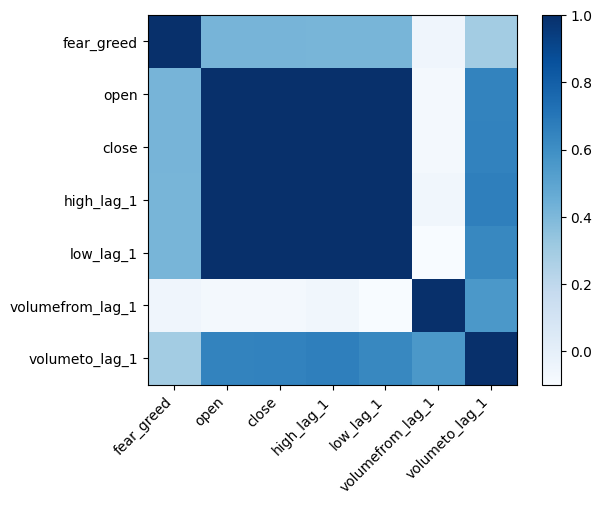

In [756]:
matrix = new_features.corr()

plt.imshow(matrix, cmap='Blues')

# adding colorbar
plt.colorbar()

# extracting variable names
variables = []
for i in matrix.columns:
    variables.append(i)

# Adding labels to the matrix
plt.xticks(range(len(matrix)), variables, rotation=45, ha='right')
plt.yticks(range(len(matrix)), variables)

# Display the plot
plt.show()

In [757]:
matrix['close'][matrix['close'] > 0.7]

open          0.998440
close         1.000000
high_lag_1    0.997890
low_lag_1     0.997638
Name: close, dtype: float64

In [758]:
X = new_features.drop(columns='close')
y = new_features['close']

# X = data.drop(columns=['close', 'high', 'low', 'volumefrom', 'volumeto', 'time'])
# y = data['close']

In [759]:
scaler = MinMaxScaler()
d = scaler.fit_transform(X)

norm_data = pd.DataFrame(d, columns=X.columns)
norm_data.head()

,fear_greed,open,high_lag_1,low_lag_1,volumefrom_lag_1,volumeto_lag_1
0,0.505618,0.900997,0.888320,0.908841,0.009932,0.047112
1,0.539326,0.915453,0.890737,0.920445,0.007395,0.040924
2,0.494382,0.914589,0.899294,0.910948,0.052850,0.157761
3,0.471910,0.905937,0.891935,0.900514,0.062538,0.180302
4,0.494382,0.918203,0.892159,0.889289,0.115961,0.315535


In [760]:

x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=42)

In [761]:
shift = data.iloc[:shift_window]
record = [51, 96959.29]

for i in range(len(shift)):
    info = shift.iloc[i][['high', 'low', 'volumefrom', 'volumeto']].to_list()
    # print(info)
    record = record + info

print(record)

record = np.array(record).reshape(1, -1)

norm_record = scaler.transform(record)




[51, 96959.29, np.float64(97046.2), np.float64(95226.61), np.float64(12161.59), np.float64(1167315867.5)]


/Users/gabrielnichio/Desktop/Estudos/Machine Learning/CD4ML/Bitcoin-prediction/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# Linear Regression

In [762]:
lr = LinearRegression()

lr.fit(x_train, y_train)


pred = lr.predict(x_test)

# lr.score(x_test, y_test)

print(mean_absolute_percentage_error(pred, y_test)*100)

2.316756171378078


In [763]:
lr.predict(record)

/Users/gabrielnichio/Desktop/Estudos/Machine Learning/CD4ML/Bitcoin-prediction/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([96790.13650318])

# XGBoost

In [764]:
import xgboost as xgb

model = xgb.XGBRegressor()
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [765]:
pred = model.predict(x_test)

In [766]:
print(mean_absolute_percentage_error(pred, y_test)*100)

2.9141382936101823


In [767]:
model.predict(record)

array([96542.945], dtype=float32)